Let us now see how SVMs work and why they improve upon logistic regression..

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Copy some code for the MNIST example from Lecture 5.

In [0]:
from sklearn.datasets import fetch_openml

X,y = fetch_openml('mnist_784',version=1,return_X_y=True)

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


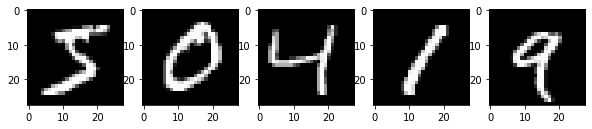

In [4]:
plt.figure(figsize=(10,4))
for index, (image, label) in enumerate(zip(X[0:5],y[0:5])):
  plt.subplot(1,5,index+1)
  plt.imshow(np.reshape(image,(28,28)), cmap=plt.cm.gray)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=1/7)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
logisticReg = LogisticRegression(penalty='l2',tol=0.1,solver='saga',C=0.001)
%time logisticReg.fit(x_train,y_train)

CPU times: user 10.7 s, sys: 0 ns, total: 10.7 s
Wall time: 10.7 s


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.1, verbose=0,
                   warm_start=False)

In [6]:
predictions = logisticReg.predict(x_test)
score = logisticReg.score(x_test,y_test)
print(score)

0.8897


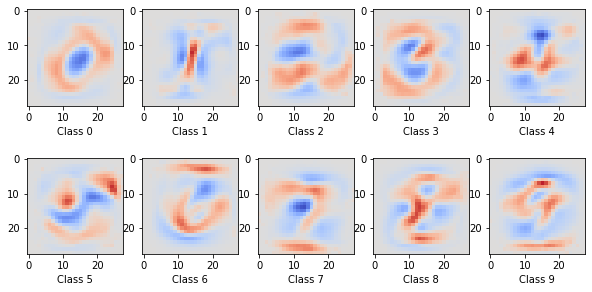

In [7]:
def plot_weights(coef):
  plt.figure(figsize=(10,5))
  scale = np.abs(coef).max()
  for i in range(10):
    l2_plot = plt.subplot(2,5,i+1)
    l2_plot.imshow(coef[i].reshape(28,28), vmin = -scale, vmax = scale, cmap=plt.cm.coolwarm)
    l2_plot.set_xlabel('Class %i' % i)

coef = logisticReg.coef_.copy()
plot_weights(coef)


OK! Learned digit models are not very human-interpretable. So we will instead try building an SVM for the same data. Actually 88% is not very good either.

In [10]:
from sklearn import svm

ntr = x_train.shape[0]
ntr1 = 5000
nts1 = 1000
Iperm = np.random.permutation(ntr1)
x_train_small = x_train[Iperm[:ntr1],:]
y_train_small = y_train[Iperm[:ntr1]]
x_test_small = x_test[Iperm[:nts1],:]
y_test_small = y_test[Iperm[:nts1]]

svc = svm.SVC(probability=False,kernel="linear",C=2.8,gamma=0.0073)
% time svc.fit(x_train_small,y_train_small)

CPU times: user 6.3 s, sys: 2.9 ms, total: 6.3 s
Wall time: 6.34 s


SVC(C=2.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0073, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
yhat = svc.predict(x_test_small)

acc = np.mean(yhat == y_test_small)
print(acc)

0.898


In [12]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_small,yhat))

[[ 92   0   0   0   0   2   0   0   0   0]
 [  0 126   1   1   0   0   0   0   1   0]
 [  0   1  84   1   0   1   1   0   4   0]
 [  0   1   1  74   0   2   0   0   2   2]
 [  0   1   1   0  96   0   0   0   0   6]
 [  3   0   0   7   1  83   1   0   3   1]
 [  1   0   1   0   0   2 102   0   0   0]
 [  0   1   0   1   3   0   0  87   0   3]
 [  3   3   2   5   1   3   1   0  77   1]
 [  1   0   1   3   8   0   0  10   3  77]]


Slightly better! Let's try visualizing the model. 

(45, 784)


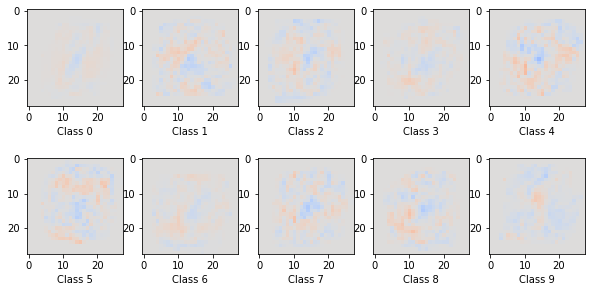

In [13]:
coef_svm = svc.coef_
plot_weights(coef_svm)
print(coef_svm.shape)

Hmm interesting. We have more coefficient vectors (45) than classes! Why is that? Multi-class classification is handled a bit strangely: we get one-vs-one classification, which means that for 10 classes we have 10C2 = 45 models. Instead, let's use a different interpretation using the support vectors.

(1786, 784)


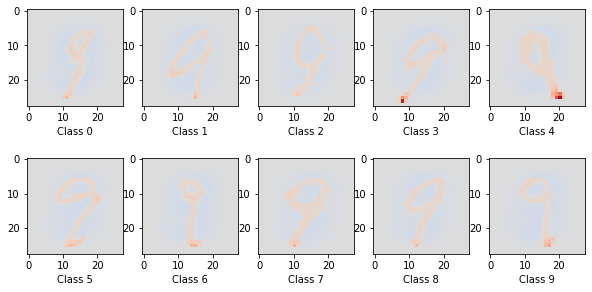

In [14]:
S = svc.support_vectors_
print(S.shape)

plot_weights(S[-10:,:])

In [15]:
print(svc.n_support_)

[136 106 201 188 195 225 148 178 200 209]


In [24]:
svcrbf = svm.SVC(probability=False,kernel="rbf",C=5,decision_function_shape='ovo',max_iter=1000)
%time svcrbf.fit(x_train_small,y_train_small)

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.4 s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
yhat_rbf = svcrbf.predict(x_test_small)
acc_rbf = np.mean(yhat_rbf == y_test_small)
print(acc_rbf)

0.927


Let's try running this on the full MNIST dataset. It may take some time..

In [26]:
# %time svcrbf.fit(x_train,y_train)
# yhat_rbf_full = svcrbf.predict(x_test)
# acc_rbf_full = np.mean(yhat_rbf_full == y_test)
# print(acc_rbf)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


CPU times: user 12min 3s, sys: 199 ms, total: 12min 4s
Wall time: 12min 5s
0.927
